#### AOS 575 Application Lab 1: Significance testing

Originally coded by Prof. Jennifer Kay (CU) with input from Elizabeth Maroon (CU ATOC/CIRES Postdoc 2018); last updated September 2, 2020 <br>
Updated/adapted for AOS 575 by Prof. Maroon (UWisc) <br>
Last updated: September 14, 2020

LEARNING GOALS: <br>
1) Working in an ipython notebook: read in netcdf file, make line plots and histograms <br>
2) Calculate statistical significance of the changes in the normalized mean using a z-statistic and a t-statistic <br>
3) Calculate confidence intervals on CESM-LE global warming using z-statistic and t-statistic


In [1]:
#import packages
import matplotlib   # library for plotting
import matplotlib.pyplot as plt # basic plotting; later you will type plt.$COMMAND
import numpy as np # basic math library  you will type np.$STUFF  e.g., np.cos(1)
import scipy.stats as stats # imports stats functions https://docs.scipy.org/doc/scipy/reference/stats.html  
import xarray  ##netcdf manipulation - slick array manipulation

LEARNING GOAL #1 <br>
Read in the data from netcdf files <br>
These data are global annual mean surface temperatures from the CESM Large Ensemble Project: https://doi.org/10.1175/BAMS-D-13-00255.1.

In [2]:
fname="TS_timeseries_cesmle_1920_2100.nc"
ds=xarray.open_dataset(fname)
ds  ## note: uncommenting this line prints information about the data you read in


<xarray.Dataset>
Dimensions:            (member: 30, year: 181)
Coordinates:
  * member             (member) int32 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30
  * year               (year) int32 1920 1921 1922 1923 ... 2097 2098 2099 2100
Data variables:
    gts_ann_allcesmle  (member, year) float32 ...
    ats_ann_allcesmle  (member, year) float32 ...
Attributes:
    case:           CESM-LE members 1-30
    creation_date:  Tue Aug  1 14:17:35 MDT 2017
    source:         ATOC4500_hw5_timeseries.ncl

Print out ds (uncomment above).  What variables, coordinates, and dimensions do you see in this dataset?

<b>Insert answer here:</b> Variables are gts_ann_allcesmle and ats_ann_allcesmle (one is global mean temperature the other is arctic temperature). Coordinates are member (ensemble member, 1-30) and year.  Dimensions are also member and year.

In [3]:
fname1="TS_timeseries_cesmle_1850.nc"
ds1=xarray.open_dataset(fname1)
gts=ds["gts_ann_allcesmle"]
ats=ds["ats_ann_allcesmle"]
year=ds["year"]
#gts  ## note: uncommenting this line prints information about the variable gts
gts_1850=ds1["gts_annual"]

<b>It's always a good idea to plot your data before you start doing any calculations.</b>  "Look at your data"!
Let's make a quick line plot of global annual mean temperature timeseries from the 1850 control and the ensemble members.

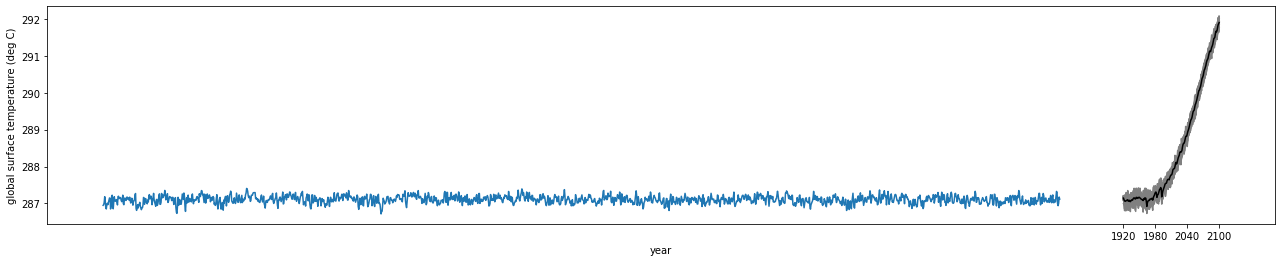

In [4]:
plt.rcParams["figure.figsize"] = [22,4]
[plt.plot(year,gts.sel(member=i),color="grey") for i in range(1,31)] ## plot all 30 ensemble members
plt.plot(year,gts.mean("member"),color="black")  ## plot ensemble mean
plt.xlabel('year')
plt.ylabel('global surface temperature (deg C)')
plt.xticks(np.arange(1920,2101,60),["1920","1980","2040","2100"])

plt.plot(gts_1850,color="C0");  ## add ";" to not print to screen plotting comments

LEARNING GOAL #2 - Assess global warming in the ensemble and compare it to the 1850 control with constant forcing <br>

With the 1850 control we have the opportunity to calculate population statistics with constant forcing. <br>
Let's find the population mean and population standard deviation from the 1850 control.  

In [5]:
gts_1850_mean=np.mean(gts_1850)
gts_1850_std=np.std(gts_1850)
print("Mean 1850 global mean surface temperature")
print(np.str(np.round(gts_1850_mean.values,2)))
print("Standard deviation in 1850 global mean surface temperature:")
print(np.str(np.round(gts_1850_std.values,2)))

Mean 1850 global mean surface temperature
287.11
Standard deviation in 1850 global mean surface temperature:
0.1


Standardize the data and plot a histogram:

Standardized mean and std in 1850 global mean surface temperature:
0.0
1.0


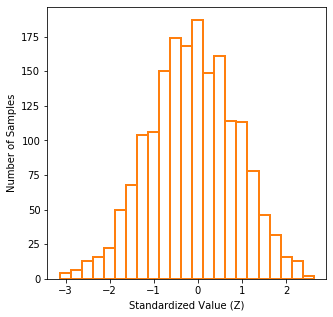

In [6]:
gts_1850_norm=(gts_1850-gts_1850_mean)/gts_1850_std
gts_1850_norm_mean=np.mean(gts_1850_norm).values
gts_1850_norm_std=np.std(gts_1850_norm).values
print("Standardized mean and std in 1850 global mean surface temperature:")
print(np.str(np.round(gts_1850_norm_mean,2)))
print(np.str(np.round(gts_1850_norm_std,2)))

xinc = np.arange(-3,3,.25)
hx=np.histogram(gts_1850_norm,xinc)
plt.rcParams["figure.figsize"] = [5,5]
plt.bar(hx[1][:-1],hx[0],edgecolor = 'C1', color = [], width = .25, linewidth = 2);
plt.ylabel('Number of Samples');
plt.xlabel('Standardized Value (Z)');

## another histogram option to try (might be deprecated)
#xinc = np.arange(-3,3,.25);
#plt.hist(gts_1850_norm,xinc);
#plt.ylabel('Number of Samples');
#plt.xlabel('Standardized Value (Z)');

Next let's calculate the global warming in the first ensemble member over a given time period. <br>
Our end goal is compare the 2020-2030 average warming to the 1850 control run and assess if the warming is statistically significant.


nyears:10

<xarray.DataArray 'gts_ann_allcesmle' (year: 10)>
array([288.1468 , 288.18713, 288.27487, 288.22516, 288.33203, 288.28644,
       288.09985, 288.30484, 288.40485, 288.3772 ], dtype=float32)
Coordinates:
    member   int32 1
  * year     (year) int32 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029
Attributes:
    NCL:             month_to_annual
    cell_methods:    time: mean
    long_name:       Surface temperature (radiative)
    units:           K
    average_op_ncl:  dim_avg over dimension(s): lon

Standardized mean CESM LE member 1:
11.18



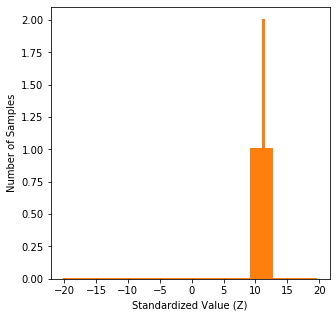

In [7]:
### Start by standardizing member 1 data using the 1850 control mean and standard deviation
startyear=2020  #Try playing with the Start and end years later.
endyear=2030
nyrs=(endyear-startyear)
print("nyears:"+np.str(nyrs))
print() #printing an empty line to format things more clearly below
gts_mem1=gts.sel(member=1).sel(year=slice(startyear,endyear-1))   #the .sel method is an easy way to subselect data
print(gts_mem1)
gts_mem1_norm=(gts_mem1-gts_1850_mean)/gts_1850_std
print() 

print("Standardized mean CESM LE member 1:")
print(np.round(np.mean(gts_mem1_norm).values,2))
print()

## plot a histogram to see the range of values
xinc = np.arange(-20,20,.25)
hx=np.histogram(gts_mem1_norm,xinc);
plt.bar(hx[1][:-1],hx[0],edgecolor = 'C1', color = 'k', width = .25, linewidth = 2);
plt.ylabel('Number of Samples');
plt.xlabel('Standardized Value (Z)');

## another histogram option to try (might be deprecated)
#xinc = np.arange(-20,20,.25)
#plt.hist(gts_mem1_norm,xinc)
#plt.ylabel('Number of Samples')
#plt.xlabel('Standardized Value (Z)')

Why is the mean of this standardized variable not centered at 0?

<b>Insert answer here:</b> If using 2020-2030 as the beginning and end times for this standardized variable, then its mean is not centered at 0 because it has been standardized with reference to the 1850-simulation's mean and standard deviation. The 1850 simulation's mean is much cooler than the CESM1-LE 2020-2030 mean temperature.

What is the probability that the mean annual global mean temperature was X assuming no global warming? <br>
Test that sample mean is equal to the population mean (null hypothesis) <br>
Assume that the Global Mean Annual Temperature is standard normal. 

In [8]:
## Using Barnes equation (1.83) to calculate probability using z-statistic
sample_mean=np.mean(gts_mem1_norm).values
print('sample_mean:',np.str(np.round(sample_mean,2)))
population_mean=gts_1850_norm_mean
population_std=gts_1850_norm_std
xstd=population_std/np.sqrt(nyrs)
z=(sample_mean-population_mean)/xstd
print("Z-statistic:")
print(np.round(z,2))
print("Probability (percent):")
prob=(1-stats.norm.cdf(z))*100
print(np.round(prob,2))

## Using Barnes equation (1.96) to calculate probability using the t-statistic
sample_mean=np.mean(gts_mem1_norm).values
sample_std=np.std(gts_mem1_norm).values
print("T-statistic:")
t=(sample_mean-population_mean)/(sample_std/(np.sqrt(nyrs-1)))
print(np.round(t,2))
print("Probability (percent):")
prob=(1-stats.t.cdf(t,nyrs-1))*100
print(np.round(prob,2))

print('ttest function from python')
#stats.ttest_ind(gts_1850_norm,gts_mem1_norm)
print(stats.ttest_ind(gts_mem1_norm,gts_1850_norm,equal_var = False)) #When equal_var is false (defaults to true),
#this means that the underlying population variances are NOT equal and this function then uses Welch's T-test


sample_mean: 11.18
Z-statistic:
35.36
Probability (percent):
0.0
T-statistic:
37.12
Probability (percent):
0.0
ttest function from python
Ttest_indResult(statistic=37.01131288736265, pvalue=3.026548718423069e-11)


What is the probability that the mean annual global mean temperature was X assuming no global warming? Do we reject the null hypothesis that the sample mean is equal to the population mean?

Insert answer here: There is a 0% chance that the annual global mean temperature from 2020-2030 has a standardized sample mean of 11.18 if it comes from the same population as the 1850-simulation. The CESM-LE annual mean temperature almost certainly has changed relative to 1850 (due to global warming). We reject the null hypothesis.

LEARNING GOAL #3 - Calculate confidence intervals on CESM-LE global warming using z-statistic and t-statistic <br>

Use the code below to calculate how much global warming occurred over the 21st century in both individual ensemble members and the ensemble mean.

In [9]:
## Compare 21st century global warming: one member vs. ensemble mean
gw_mem1=gts.sel(member=1).sel(year=slice(2080,2100)).mean("year")- \
        gts.sel(member=1).sel(year=slice(2000,2020)).mean("year")
gw_mean=(gts.sel(year=slice(2080,2100)).mean("year").mean("member"))- \
        (gts.sel(year=slice(2000,2020)).mean("year").mean("member"))
print(np.round(gw_mem1.values,2))
print(np.round(gw_mean.values,2))

3.7
3.63


Next - let's calculate emsemble statistics about 21st century global warming

In [10]:
nmembers=30
temp=(gts.sel(member=slice(1,nmembers)).sel(year=slice(2080,2100)).mean("year")-\
      gts.sel(member=slice(1,nmembers)).sel(year=slice(2000,2020)).mean("year"))
gw_mean_mem=temp.mean("member")
gw_std_mem=temp.std("member")
gw_min_mem=temp.min("member")
gw_max_mem=temp.max("member")
print("mean: ",np.str(np.round(gw_mean_mem.values,2)))
print("stdev: ",np.str(np.round(gw_std_mem.values,2)))
print("min: ",np.str(np.round(gw_min_mem.values,2)))
print("max: ",np.str(np.round(gw_max_mem.values,2)))

mean:  3.63
stdev:  0.06
min:  3.51
max:  3.75


Let's add confidence intervals to the estimated global warming <br>
Specifically - we'll compare confidence intervals calculated using t-statistic and z-statistic <br>

Calculate the 95% and 99% confidence limits on the 21st century warming using t-statistic <br>
Assume that the global warming is normally distributed.

In [11]:
N=nmembers
df=N-1

## Note: Python calculates left/lower-tail probabilities by default, so for the 95% confidence interval, use 0.975
tstat95=stats.t.ppf(0.975,df)
low_limit95=gw_mean_mem-tstat95*(gw_std_mem/np.sqrt(nmembers-1))
high_limit95=gw_mean_mem+tstat95*(gw_std_mem/np.sqrt(nmembers-1))
print("95% confidence limits - t-statistic")
print(np.round(low_limit95.values,2))
print(np.round(high_limit95.values,2))
print()

## Note: Python calculates left/lower-tail probabilities by default, so for the 99% confidence interval, use 0.995
tstat99=stats.t.ppf(0.995,df)
low_limit99=gw_mean_mem-tstat99*(gw_std_mem/np.sqrt(nmembers-1))
high_limit99=gw_mean_mem+tstat99*(gw_std_mem/np.sqrt(nmembers-1))
print("99% confidence limits - t-statistic")
print(np.round(low_limit99.values,2))
print(np.round(high_limit99.values,2))
print()

#### Calculate the 95% and 99% confidence limits on the 21st century warming using z-statistic
#### Assume that the global warming is normally distributed.

## Note: Python calculates left/lower-tail probabilities by default, so for the 95% confidence interval, use 0.975
zstat95=stats.norm.ppf(0.975)
low_limit95=gw_mean_mem-zstat95*(gw_std_mem/np.sqrt(nmembers))
high_limit95=gw_mean_mem+zstat95*(gw_std_mem/np.sqrt(nmembers))
print("95% confidence limits - z-statistic")
print(np.round(low_limit95.values,2))
print(np.round(high_limit95.values,2))
print()

## Note: Python calculates left/lower-tail probabilities by default, so for the 99% confidence interval, use 0.995
zstat99=stats.norm.ppf(0.995)
low_limit99=gw_mean_mem-zstat99*(gw_std_mem/np.sqrt(nmembers))
high_limit99=gw_mean_mem+zstat99*(gw_std_mem/np.sqrt(nmembers))
print("99% confidence limits - z-statistic")
print(np.round(low_limit99.values,2))
print(np.round(high_limit99.values,2))
print()

95% confidence limits - t-statistic
3.61
3.66

99% confidence limits - t-statistic
3.6
3.67

95% confidence limits - z-statistic
3.61
3.66

99% confidence limits - z-statistic
3.6
3.66



Plot a histogram of global warming - 

[3.695221  3.636963  3.652832  3.6441956 3.634613  3.5675354 3.6606445
 3.7267761 3.5054932 3.6834412 3.5503845 3.5212708 3.5517578 3.6859741
 3.619995  3.7277527 3.6286316 3.541504  3.5733337 3.5706787 3.6762085
 3.6142273 3.6184998 3.6961365 3.6150513 3.6669922 3.6224976 3.688324
 3.7549744 3.6689758]
[3.45 3.5  3.55 3.6  3.65 3.7  3.75]


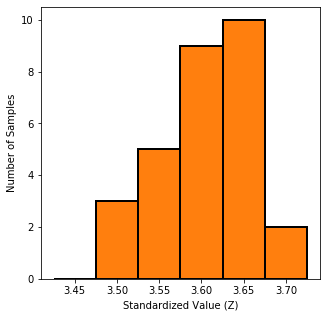

In [12]:
gw_allmem=gts.sel(member=slice(1,nmembers)).sel(year=slice(2080,2100)).mean("year")- \
        gts.sel(member=slice(1,nmembers)).sel(year=slice(2000,2020)).mean("year")
print(gw_allmem.values)

## plot a histogram to see the range of values
wid=0.05
xinc = np.arange(3.45,3.8,wid)
print(xinc)
hx=np.histogram(gw_allmem,xinc)
plt.bar(hx[1][:-1],hx[0],edgecolor = 'k', color = 'C1', width = wid, linewidth = 2);
plt.ylabel('Number of Samples');
plt.xlabel('Standardized Value (Z)');

### another histogram option
#xinc = np.arange(3.5,3.8,.05)
#plt.hist(gw_allmem,xinc);
#plt.ylabel('Number of Samples');
#plt.xlabel('Standardized Value (Z)');

Was normal distribution a good approximation?

<b>Insert answer here:</b> No. The above distribution of standardized global mean temperature does not appear normal. It looks skewed to the left.

What if you you only had 6 ensemble members?  Estimate your confidence interval using a t-statistic.
Calculate statistics for the 21st century global warming

In [13]:
nmembers=6
temp=(gts.sel(member=slice(1,nmembers)).sel(year=slice(2080,2100)).mean("year")-\
      gts.sel(member=slice(1,nmembers)).sel(year=slice(2000,2020)).mean("year"))
print(temp)
gw_mean_mem=temp.mean("member")
gw_std_mem=temp.std("member")
gw_min_mem=temp.min("member")
gw_max_mem=temp.max("member")

print("mean: ",np.str(np.round(gw_mean_mem.values,2)))
print("stdev: ",np.str(np.round(gw_std_mem.values,2)))
print("min: ",np.str(np.round(gw_min_mem.values,2)))
print("max: ",np.str(np.round(gw_max_mem.values,2)))

<xarray.DataArray 'gts_ann_allcesmle' (member: 6)>
array([3.695221 , 3.636963 , 3.652832 , 3.6441956, 3.634613 , 3.5675354],
      dtype=float32)
Coordinates:
  * member   (member) int32 1 2 3 4 5 6
mean:  3.64
stdev:  0.04
min:  3.57
max:  3.7


In [14]:
#### Calculate the 95% and 99% confidence limits on the 21st century warming using t-statistic
#### Assume that the global warming is normally distributed.  (See page 18 of Barnes notes)
N=nmembers
df=N-1

## Note: Python calculates left/lower-tail probabilities by default, so for the 95% confidence interval, use 0.975
tstat95=stats.t.ppf(0.975,df)
low_limit95=gw_mean_mem-tstat95*(gw_std_mem/np.sqrt(nmembers-1))
high_limit95=gw_mean_mem+tstat95*(gw_std_mem/np.sqrt(nmembers-1))
print("95% confidence limits - t-statistic")
print(low_limit95.values)
print(high_limit95.values)
print()

## Note: Python calculates left/lower-tail probabilities by default, so for the 99% confidence interval, use 0.995
tstat99=stats.t.ppf(0.995,df)  #### FIXED - this said stats.norm.ppf instead of stats.t.ppf
low_limit99=gw_mean_mem-tstat99*(gw_std_mem/np.sqrt(nmembers-1))
high_limit99=gw_mean_mem+tstat99*(gw_std_mem/np.sqrt(nmembers-1))
print("99% confidence limits - t-statistic")
print(low_limit99.values)
print(high_limit99.values)

95% confidence limits - t-statistic
3.5952689933866235
3.681851119986179

99% confidence limits - t-statistic
3.5706549020445166
3.706465211328286


Based on what you've learned in this exercise, what can you conclude about the CESM's projected global temperature during this decade? 

When you use CESM to model the preindustrial period (1850), the historical period, and the near future: By 2020-2030 (NOW-10-years-from-now), there has been unambigous warming that is statistically signficantly different from preindustrial (1850) conditions. Even we you account for natural variability (by using multiple ensemble members, multiple realizations), global temperature has unambigously increased. 

#### Questions from pdf:

1. There are 2600 years in the 1850 control run. This is enough for a very stable population
mean and standard deviation. What is the population mean and standard deviation for
the 1850 control run? Standardize the 1850 surface temperature and then re-report the
population mean and standard deviation. What are they now? Plot a histogram of the 
1850 simulation surface temperature. Does it look like a normal distribution (Gaussian)
to you?

<b>Answer:</b> Drawn from above printouts:<br>
Population mean from 1850 control run: 287.11 K  <br>
Population standard deviation from 1850 control run: 0.1 K <br>
By definition, after standardizing the population mean of the 1850 control run is 0 and its standard deviation is 1 <br>
The distribution of the 1850 surface temperature distribution looks normal. 

2. Calculate the global warming in one ensemble member during 2020-2030 (as defined
in the notebook). Compare this warming relative to the 1850 simulation. Is there
statistically significant warming? Use hypothesis testing and state the 5 steps. What is
the null hypothesis? What is the difference between using the z and t statistics? What
is the probability that the warming in this one ensemble member occurred by chance?
Play with the start and end years. See how that changes your answers. When does
warming become statistically significant? 

<b>Answer:</b> The standardized sample mean of 2020-2030 from one ensemble member has a Z-statistic of 11. The 2020-2030 mean is 11 standard deviations to the right of the 1850-simulation's population-mean! 11-sigma is definitely significant, but let's be more formal about it and use all 5 steps to determine this: <br>
a. State significance level: $\alpha=0.05$. <br>
b. State the null hypothesis H0 and alternative hypothesis H1: H0: the global temperature in 2020-2030 hasn't changed since 1850. H1: The global temperature has changed. <br>
c. State the statistic to be used and assumptions required to use it: It is more defensible to use the t-statistic to compare our 10-year sample mean to the population mean (1850 simulation). N<30.  We are assuming that the values that compose the sample mean is derived from a normal distribution. <br>
d. State the critical region: Could argue that we have a strong a priori assumption for warming (one-tailed test).  Looking for a p-value that is less than 0.05 in that case. If two-tailed test, looking for a p-value under 0.025. <br>
e. Evaluate the statistic and state the conclusion: p-value has infinitely small magnitude, effectively equal to 0. Global temperature has changed.<br>

When does warming becomes statistically signficant? This requires altering the start and end years in 10 year increments. I first see a statistically significant result for 1980-1990.

3. The power of a Large Ensemble approach is that it provides many potential realizations
of the climate and allows a rigorous quantification of the effects of greenhouse gas
emissions by “averaging out” the natural variability. Plot a histogram using many of
the CESM-LE ensemble members. With such a large sample, does it look like global
surface temperature is a normally distributed quantity? You can use these ensemble
members to provide a confidence interval on the ensemble mean (i.e., the forced
response) using the ensemble standard deviation (the natural variability). How do the
confidence intervals change if you change the number of ensemble members (e.g., try
30, 10, 6, or 3 members). What’s the difference between the 95% and 99% confidence
intervals?

<b>Answer:</b> Drawn from above printouts/figures: <br>
The above global surface temperature historgram using multiple CESM ensemble members (multiple samples!) does not appear normally distributed. <br>
With 3 ensemble members, the 95% confidence interval on the 2020-2030 CESM ensemble mean is: +3.59 to +3.74 K<br>
With 3 ensemble members, the 99% confidence interval on the 2020-2030 CESM ensemble mean is: +3.49 to +3.83 K <br>
With 6 ensemble members, the 95% confidence interval on the 2020-2030 CESM ensemble mean is: +3.60 to +3.68 K <br>
With 6 ensemble members, the 99% confidence interval on the 2020-2030 CESM ensemble mean is: +3.57 to +3.71 K<br>
With 10 ensemble members, the 95% confidence interval on the 2020-2030 CESM ensemble mean is: +3.60 to +3.69 K <br>
With 10 ensemble members, the 99% confidence interval on the 2020-2030 CESM ensemble mean is: +3.58 to +3.71 K<br>
With 30 ensemble members, the 95% confidence interval on the 2020-2030 CESM ensemble mean is: +3.61 to +3.66 K <br>
With 30 ensemble members, the 99% confidence interval on the 2020-2030 CESM ensemble mean is: +3.61 to +3.67 K<br>

Regardless of number of ensemble members, the 99% confidence intervals is larger than the 95% confidence interval. With more ensemble members, the confidence intervals shrink.